In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.base import BaseEstimator, ClassifierMixin
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions import Normal

class TorchMultivariateGaussianClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, class_params=None, device="cpu"):
        """
        Initialize the classifier with class parameters.

        Parameters:
        class_params: dict
            A dictionary where keys are class labels and values are dictionaries with
            'mean' (vector), 'cov' (matrix), and 'prior' for each class.
        device: str
            The device to use for computations ('cpu' or 'cuda').
        """
        self.class_params = class_params if class_params is not None else {}
        self.device = torch.device(device)
        self.classes_ = torch.tensor(list(self.class_params.keys()), device=self.device)
        self.n_features = len(self.class_params[0]["cov"])
        self.n_classes = len(self.classes_)
    
    def fit(self, X, y=None):
        """
        Fit method for compatibility. This classifier doesn't require fitting.
        """
        self.classes_ = torch.tensor(list(self.class_params.keys()), device=self.device)
        return self
    
    def predict_proba(self, X):
        """
        Predict the probability of each class for the given input data X.

        Parameters:
        X: torch.Tensor or array-like of shape (n_samples, n_features)
            Input features.

        Returns:
        probs: torch.Tensor of shape (n_samples, n_classes)
            Predicted probabilities for each class.
        """
        if not isinstance(X, torch.Tensor):
            X = torch.tensor(X, device=self.device, dtype=torch.float32)
        
        probs = torch.zeros((X.shape[0], len(self.classes_)), device=self.device)
        for i, c in enumerate(self.classes_):
            mean = torch.tensor(self.class_params[int(c)]["mean"], device=self.device, dtype=torch.float32)
            cov = torch.tensor(self.class_params[int(c)]["cov"], device=self.device, dtype=torch.float32)
            prior = self.class_params[int(c)]["prior"]
            
            # Multivariate normal distribution
            mvn_dist = MultivariateNormal(mean, covariance_matrix=cov)
            px_given_y = torch.exp(mvn_dist.log_prob(X))
            
            # Combine with prior
            probs[:, i] = px_given_y * prior
        
        # Normalize to get P(y=c|x)
        probs /= probs.sum(dim=1, keepdim=True)
        return probs
    
    def predict(self, X):
        """
        Predict the class label for each sample in X.

        Parameters:
        X: torch.Tensor or array-like of shape (n_samples, n_features)
            Input features.

        Returns:
        predictions: torch.Tensor of shape (n_samples,)
            Predicted class labels.
        """
        probs = self.predict_proba(X)
        return self.classes_[torch.argmax(probs, dim=1)]
    
    def generate_data(self, n_samples=100):
        """
        Generate synthetic data using the predefined class parameters.

        Parameters:
        n_samples: int
            Number of samples to generate.

        Returns:
        X: torch.Tensor of shape (n_samples, n_features)
            Generated features.
        y: torch.Tensor of shape (n_samples,)
            Generated labels.
        """
        X = []
        y = []
        for _ in range(n_samples):
            # Sample class based on priors
            sampled_class = torch.multinomial(
                torch.tensor([self.class_params[int(c)]["prior"] for c in self.classes_], device=self.device),
                num_samples=1
            ).item()
            mean = torch.tensor(self.class_params[int(self.classes_[sampled_class])]["mean"], device=self.device, dtype=torch.float32)
            cov = torch.tensor(self.class_params[int(self.classes_[sampled_class])]["cov"], device=self.device, dtype=torch.float32)
            
            # Sample feature vector from the corresponding multivariate Gaussian
            mvn_dist = MultivariateNormal(mean, covariance_matrix=cov)
            sampled_x = mvn_dist.sample()
            X.append(sampled_x)
            y.append(self.classes_[sampled_class].item())
        
        return torch.stack(X), torch.tensor(y, device=self.device)

class TorchGaussianSyntheticClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, class_params=None, device="cpu"):
        """
        Initialize the classifier with class parameters.

        Parameters:
        class_params: dict
            A dictionary where keys are class labels and values are dictionaries with
            'mean', 'std', and 'prior' for each class.
        device: str
            The device to use for computations ('cpu' or 'cuda').
        """
        self.class_params = class_params if class_params is not None else {}
        self.device = torch.device(device)
        self.classes_ = torch.tensor(list(self.class_params.keys()), device=self.device)
        self.n_features = 1
        self.n_classes = len(self.classes_)
    
    def fit(self, X, y=None):
        """
        Fit method for compatibility. This classifier doesn't require fitting.
        """
        self.classes_ = torch.tensor(list(self.class_params.keys()), device=self.device)
        return self
    
    def predict_proba(self, X):
        """
        Predict the probability of each class for the given input data X.

        Parameters:
        X: torch.Tensor or array-like of shape (n_samples,)
            Input features.

        Returns:
        probs: torch.Tensor of shape (n_samples, n_classes)
            Predicted probabilities for each class.
        """
        if not isinstance(X, torch.Tensor):
            X = torch.tensor(X, device=self.device, dtype=torch.float32)
        
        probs = torch.zeros((len(X), len(self.classes_)), device=self.device)
        for i, c in enumerate(self.classes_):
            mean = self.class_params[int(c)]["mean"]
            std = self.class_params[int(c)]["std"]
            prior = self.class_params[int(c)]["prior"]
            
            # Calculate Gaussian PDF: P(x|y=c)
            normal_dist = Normal(loc=mean, scale=std)
            px_given_y = torch.exp(normal_dist.log_prob(X))
            
            # Combine with prior: P(x|y=c) * P(y=c)
            probs[:, i] = px_given_y * prior
        
        # Normalize to get P(y=c|x)
        probs /= probs.sum(dim=1, keepdim=True)
        return probs
    
    def predict(self, X):
        """
        Predict the class label for each sample in X.

        Parameters:
        X: torch.Tensor or array-like of shape (n_samples,)
            Input features.

        Returns:
        predictions: torch.Tensor of shape (n_samples,)
            Predicted class labels.
        """
        probs = self.predict_proba(X)
        return self.classes_[torch.argmax(probs, dim=1)]

    def generate_data(self, n_samples=100):
        """
        Generate synthetic data using the predefined class parameters.

        Parameters:
        n_samples: int
            Number of samples to generate.

        Returns:
        X: torch.Tensor of shape (n_samples,)
            Generated features.
        y: torch.Tensor of shape (n_samples,)
            Generated labels.
        """
        X = []
        y = []
        for _ in range(n_samples):
            # Sample class based on priors
            sampled_class = torch.multinomial(
                torch.tensor([self.class_params[int(c)]["prior"] for c in self.classes_], device=self.device),
                num_samples=1
            ).item()
            # Sample feature value from the corresponding Gaussian
            mean = self.class_params[int(self.classes_[sampled_class])]["mean"]
            std = self.class_params[int(self.classes_[sampled_class])]["std"]
            normal_dist = Normal(loc=mean, scale=std)
            sampled_x = normal_dist.sample().item()
            X.append(sampled_x)
            y.append(self.classes_[sampled_class].item())
        
        return torch.tensor(X, device=self.device), torch.tensor(y, device=self.device)

def goodman_kruskal_gamma(x, y):
    """
    Compute Goodman and Kruskal's Gamma for two ordinal variables.
    
    Parameters:
    x, y: Lists or arrays of ordinal data (same length)
    
    Returns:
    gamma: Goodman and Kruskal's Gamma
    """
    if len(x) != len(y):
        raise ValueError("Both variables must have the same length.")
    
    concordant = 0
    discordant = 0
    
    n = len(x)
    for i in range(n - 1):
        for j in range(i + 1, n):
            # Determine concordance or discordance
            if (x[i] > x[j] and y[i] > y[j]) or (x[i] < x[j] and y[i] < y[j]):
                concordant += 1
            elif (x[i] > x[j] and y[i] < y[j]) or (x[i] < x[j] and y[i] > y[j]):
                discordant += 1
    
    # Compute Gamma
    if concordant + discordant == 0:
        return 0  # Avoid division by zero
    gamma = (concordant - discordant) / (concordant + discordant)
    return gamma

from torchcp.classification.score import APS, THR, SAPS
aps = APS(score_type="identity", randomized=False)
lac = THR(score_type="identity",)
saps = SAPS(score_type="identity",randomized=False)

class_params_1f_2c = {
    0: {"mean": 1, "std": 1, "prior": 0.3},
    1: {"mean": 3, "std": 1, "prior": 0.4},
    # 2: {"mean": 4, "std": 2.2, "prior": 0.3},
}   

class_params_1f_3c = {
    0: {"mean": 1, "std": 1, "prior": 0.3},
    1: {"mean": 3, "std": 1, "prior": 0.4},
    2: {"mean": 4, "std": 2.2, "prior": 0.3},
}   

# Initialize and fit the generator
class_params_2d_3c = {
    0: {
        "mean": [3.0, 2.0],  # Mean vector for class 0
        "cov": [
            [1.0, 0.5],
            [0.5, 1.2],
            # [0.3, 0.4, 0.8]
        ],  # Covariance matrix for class 0
        "prior": 0.3  # Prior probability for class 0
    },
    1: {
        "mean": [3.0, 4.0],  # Mean vector for class 1
        "cov": [
            [1.5, 0.3],
            [0.3, 1.1],
            # [0.2, 0.1, 0.9]
        ],  # Covariance matrix for class 1
        "prior": 0.4  # Prior probability for class 1
    },
    2: {
        "mean": [1.0, 2.0],  # Mean vector for class 2
        "cov": [
            [1.2, 0.4],
            [0.4, 1.3],
            # [0.3, 0.5, 1.4]
        ],  # Covariance matrix for class 2
        "prior": 0.3  # Prior probability for class 2
    },
}

# Initialize and fit the generator
class_params_3d_3c = {
    0: {
        "mean": [3.0, 2.0, 4.0],  # Mean vector for class 0
        "cov": [
            [1.0, 0.5, 0.3],
            [0.5, 1.2, 0.4],
            [0.3, 0.4, 0.8]
        ],  # Covariance matrix for class 0
        "prior": 0.3  # Prior probability for class 0
    },
    1: {
        "mean": [3.0, 4.0, 1.0],  # Mean vector for class 1
        "cov": [
            [1.5, 0.3, 0.2],
            [0.3, 1.1, 0.1],
            [0.2, 0.1, 0.9]
        ],  # Covariance matrix for class 1
        "prior": 0.4  # Prior probability for class 1
    },
    2: {
        "mean": [1.0, 2.0, 2.0],  # Mean vector for class 2
        "cov": [
            [1.2, 0.4, 0.3],
            [0.4, 1.3, 0.5],
            [0.3, 0.5, 1.4]
        ],  # Covariance matrix for class 2
        "prior": 0.3  # Prior probability for class 2
    },
}


# Initialize and fit the generator
class_params_2d_2c = {
    0: {
        "mean": [3.0, 2.0],  # Mean vector for class 0
        "cov": [
            [1.0, 0.5],
            [0.5, 1.2],
        ],  # Covariance matrix for class 0
        "prior": 0.3  # Prior probability for class 0
    },
    1: {
        "mean": [2.0, 3.0],  # Mean vector for class 1
        "cov": [
            [1.5, 0.3],
            [0.3, 1.1],
        ],  # Covariance matrix for class 1
        "prior": 0.4  # Prior probability for class 1
    },
    # 2: {
    #     "mean": [1.0, 2.0, 2.0],  # Mean vector for class 2
    #     "cov": [
    #         [1.2, 0.4],
    #         [0.4, 1.3],
    #         # [0.3, 0.5, 1.4]
    #     ],  # Covariance matrix for class 2
    #     "prior": 0.3  # Prior probability for class 2
    # },
}

clf_1d_2c = TorchGaussianSyntheticClassifier(class_params=class_params_1f_2c, device="cpu")
clf_1d_3c = TorchGaussianSyntheticClassifier(class_params=class_params_1f_3c, device="cpu")
clf_3d_3c = TorchMultivariateGaussianClassifier(class_params=class_params_3d_3c, device="cpu")
clf_2d_2c = TorchMultivariateGaussianClassifier(class_params=class_params_2d_2c, device="cpu")

/home/jonas/anaconda3/envs/plnet/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class OracleAnnotator:
    def __init__(self,score, generator):
        self.score = score
        self.classes_ = generator.classes_
        self.generator = generator

    # we assume y is already label encoded
    def get_conformity(self, X, y):
        y_pred_proba = self.generator.predict_proba(X)
        scores = self.score(y_pred_proba, y)
        return scores

In [3]:
from mapie.classification import MapieClassifier
from mapie.conformity_scores.sets import APSConformityScore, LACConformityScore, NaiveConformityScore, TopKConformityScore
from util.ranking_datasets import LabelPairDataset
from models.ranking_models import LabelRankingModel
from torch.utils.data.dataloader import DataLoader
from sklearn.datasets import make_classification
from scipy.stats import kendalltau
import matplotlib.pyplot as plt
from models.ranking_models import SortLayer
import torch

def fit_model_with_all_pairs(X_train, y_train, oracle_annotator, generator, learning_rate = 0.01, num_epochs=200):
    conformities = oracle_annotator.get_conformity(torch.tensor(X_train),torch.tensor(y_train)).detach().numpy()

    unique_elements, counts = np.unique(conformities, return_counts=True)
    non_unique_elements = unique_elements[counts > 1]
    non_unique_indices = np.where(np.isin(conformities, non_unique_elements))[0]
    mask = np.ones(conformities.shape, dtype=bool)  # Start with all True
    mask[non_unique_indices] = False       # Set False for non-unique indices


    X_train = X_train[mask]
    y_train = y_train[mask]
    conformities = conformities[mask]

    sort_idx = (-conformities).argsort(axis=0).flatten()
    X_sorted = X_train[sort_idx]
    y_sorted = y_train[sort_idx]

    
    X_pairs = np.array([(X_sorted[i], X_sorted[j]) for i in range(len(X_sorted)) for j in range(i + 1, len(X_sorted))])
    y_pairs = np.array([(y_sorted[i], y_sorted[j]) for i in range(len(y_sorted)) for j in range(i + 1, len(y_sorted))])
    y_pairs = np.expand_dims(y_pairs,axis=-1)




    ds = LabelPairDataset()
    ds.create_from_numpy_pairs(X_pairs, y_pairs)
    pair_loader = DataLoader(ds, batch_size=64)
    # ds_val = LabelPairDataset()
    # ds_val.create_from_numpy_pairs(X_pairs, y_pairs)
    # val_loader = DataLoader(ds_val, batch_size=64)
    model = LabelRankingModel(input_dim=generator.n_features, hidden_dims=2*[10*generator.n_features], activations=[torch.nn.Sigmoid(), torch.nn.Sigmoid()], output_dim=len(generator.classes_))
    model.num_classes = generator.n_classes
    device = next(model.parameters()).device
    model._fit(pair_loader, val_loader=None, num_epochs=num_epochs, learning_rate=learning_rate, patience=num_epochs, verbose=True)
    return model

def conduct_oracle_experiment(score, num_instances_to_check, generator, learning_rate = 0.01, num_epochs=1000):
    tau_corrs = []
    gamma_corrs = []
    # Generate a small dataset
    # create 
    oracle_annotator = OracleAnnotator(generator=generator, score=score)
    models = []

    for num_instances in num_instances_to_check:
        X_gen, _ = generator.generate_data(n_samples=num_instances)
        X_train = X_gen.repeat_interleave(generator.n_classes, dim=0)
        y_train = np.tile(generator.classes_, num_instances)

        model = fit_model_with_all_pairs(X_train, y_train, oracle_annotator, generator, learning_rate=learning_rate, num_epochs=num_epochs)

        # generate data from data generating process and check whether the learned non-conformity relation sorts them correctly
        X_test, y_test = generator.generate_data(n_samples=100)
        # X_test = X_gen.repeat_interleave(3, dim=0)
        # y_test = np.tile(generator.classes_, 100)
        skills_from_model = np.take_along_axis(model.predict_class_skills(X_test), y_test[:,np.newaxis].detach().numpy(), axis=1)
        conformity_scores = oracle_annotator.get_conformity(torch.tensor(X_test), torch.tensor(y_test))
        tau_corr, p_value = kendalltau(skills_from_model, conformity_scores)
        tau_corrs.append(tau_corr)
        gamma_corr = goodman_kruskal_gamma(skills_from_model,conformity_scores)
        gamma_corrs.append(gamma_corr)
        models.append(model)
    return tau_corrs, gamma_corrs, skills_from_model, conformity_scores, models, X_train, y_train

In [7]:
clf = clf_2d_2c

oracle_annotator_lac = OracleAnnotator(generator=clf, score=lac)
oracle_annotator_aps = OracleAnnotator(generator=clf, score=aps)
oracle_annotator_saps = OracleAnnotator(generator=clf, score=saps)
num_instances = 50
X_gen, _ = clf.generate_data(n_samples=num_instances)
X_train = X_gen.repeat_interleave(clf.n_classes, dim=0)
y_train = np.tile(clf.classes_, num_instances)

model_aps = fit_model_with_all_pairs(X_train, y_train, oracle_annotator_aps, clf, learning_rate=0.01,num_epochs=1000)
model_lac = fit_model_with_all_pairs(X_train, y_train, oracle_annotator_lac, clf, learning_rate=0.01,num_epochs=150)

/tmp/ipykernel_8993/749784010.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  conformities = oracle_annotator.get_conformity(torch.tensor(X_train),torch.tensor(y_train)).detach().numpy()


Epoch 1/1000
  Train Loss: 0.0366
Epoch 2/1000
  Train Loss: 0.0297
Epoch 3/1000
  Train Loss: 0.0305
Epoch 4/1000
  Train Loss: 0.0282
Epoch 5/1000
  Train Loss: 0.0253
Epoch 6/1000
  Train Loss: 0.0221
Epoch 7/1000
  Train Loss: 0.0199
Epoch 8/1000
  Train Loss: 0.0187
Epoch 9/1000
  Train Loss: 0.0178
Epoch 10/1000
  Train Loss: 0.0170
Epoch 11/1000
  Train Loss: 0.0161
Epoch 12/1000
  Train Loss: 0.0151
Epoch 13/1000
  Train Loss: 0.0140
Epoch 14/1000
  Train Loss: 0.0129
Epoch 15/1000
  Train Loss: 0.0120
Epoch 16/1000
  Train Loss: 0.0112
Epoch 17/1000
  Train Loss: 0.0106
Epoch 18/1000
  Train Loss: 0.0101
Epoch 19/1000
  Train Loss: 0.0096
Epoch 20/1000
  Train Loss: 0.0093
Epoch 21/1000
  Train Loss: 0.0090
Epoch 22/1000
  Train Loss: 0.0087
Epoch 23/1000
  Train Loss: 0.0085
Epoch 24/1000
  Train Loss: 0.0082
Epoch 25/1000
  Train Loss: 0.0080
Epoch 26/1000
  Train Loss: 0.0078
Epoch 27/1000
  Train Loss: 0.0077
Epoch 28/1000
  Train Loss: 0.0076
Epoch 29/1000
  Train Loss: 0

kendall tau lac SignificanceResult(statistic=0.9935353535353537, pvalue=1.4209020695312974e-48)
kendall tau aps SignificanceResult(statistic=-0.2899524770690272, pvalue=5.662835006582638e-05)


/tmp/ipykernel_8993/334288773.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  conformity_scores_lac = oracle_annotator_lac.get_conformity(torch.tensor(X_train), torch.tensor(y_train))
/tmp/ipykernel_8993/334288773.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  conformity_scores_aps = oracle_annotator_aps.get_conformity(torch.tensor(X_train), torch.tensor(y_train))


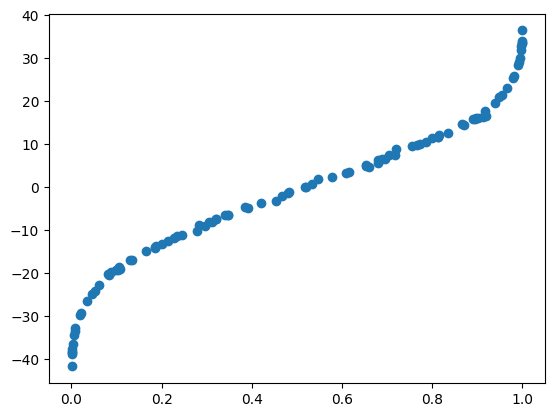

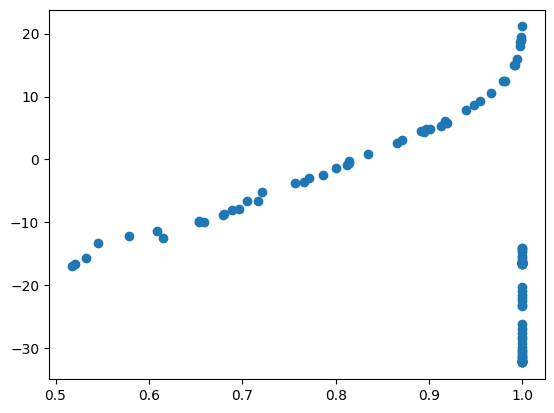

In [8]:
skills_lac = np.take_along_axis(model_lac.predict_class_skills(X_train), y_train[:,np.newaxis], axis=1)
skills_aps = np.take_along_axis(model_aps.predict_class_skills(X_train), y_train[:,np.newaxis], axis=1)
conformity_scores_lac = oracle_annotator_lac.get_conformity(torch.tensor(X_train), torch.tensor(y_train))
conformity_scores_aps = oracle_annotator_aps.get_conformity(torch.tensor(X_train), torch.tensor(y_train))

unique_elements, counts = np.unique(conformity_scores_aps, return_counts=True)
non_unique_elements = unique_elements[counts > 1]
non_unique_indices = np.where(np.isin(conformity_scores_aps, non_unique_elements))[0]

tied_sk = skills_aps[non_unique_indices]
tied_nc = conformity_scores_aps[non_unique_indices]
unique_sk = skills_aps[~non_unique_indices]
unique_nc = conformity_scores_aps[~non_unique_indices]
print("kendall tau lac", kendalltau(skills_lac, conformity_scores_lac))
print("kendall tau aps", kendalltau(skills_aps, conformity_scores_aps))

plt.scatter(conformity_scores_lac, skills_lac)
plt.show()
plt.scatter(conformity_scores_aps, skills_aps)
# plt.scatter(unique_nc, unique_sk)
# plt.scatter(tied_nc, tied_sk, color="orange", label="tie")
plt.show()

kendall tau lac SignificanceResult(statistic=0.9780785987880493, pvalue=4.0380291644799653e-47)
kendall tau aps SignificanceResult(statistic=0.31214198005677996, pvalue=5.870626598400308e-06)


/tmp/ipykernel_8993/1782319617.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  conformity_scores_lac = oracle_annotator_lac.get_conformity(torch.tensor(X_test), torch.tensor(y_test))
/tmp/ipykernel_8993/1782319617.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  conformity_scores_aps = oracle_annotator_aps.get_conformity(torch.tensor(X_test), torch.tensor(y_test))


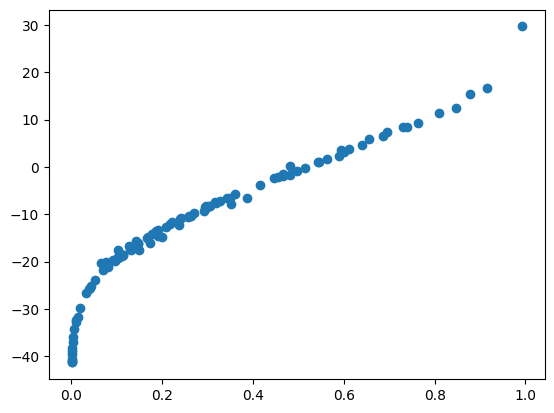

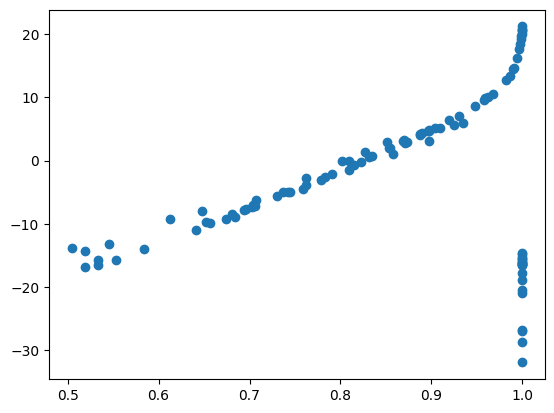

In [9]:
X_test, y_test = clf.generate_data(100)
skills_lac = np.take_along_axis(model_lac.predict_class_skills(X_test), y_test.detach().numpy()[:,np.newaxis], axis=1)
skills_aps = np.take_along_axis(model_aps.predict_class_skills(X_test), y_test.detach().numpy()[:,np.newaxis], axis=1)
conformity_scores_lac = oracle_annotator_lac.get_conformity(torch.tensor(X_test), torch.tensor(y_test))
conformity_scores_aps = oracle_annotator_aps.get_conformity(torch.tensor(X_test), torch.tensor(y_test))

unique_elements, counts = np.unique(conformity_scores_aps, return_counts=True)
non_unique_elements = unique_elements[counts > 1]
non_unique_indices = np.where(np.isin(conformity_scores_aps, non_unique_elements))[0]

tied_sk = skills_aps[non_unique_indices]
tied_nc = conformity_scores_aps[non_unique_indices]
unique_sk = skills_aps[~non_unique_indices]
unique_nc = conformity_scores_aps[~non_unique_indices]
print("kendall tau lac", kendalltau(skills_lac, conformity_scores_lac))
print("kendall tau aps", kendalltau(skills_aps, conformity_scores_aps))

plt.scatter(conformity_scores_lac, skills_lac)
plt.show()
plt.scatter(conformity_scores_aps, skills_aps)
# plt.scatter(unique_nc, unique_sk)
# plt.scatter(tied_nc, tied_sk, color="orange", label="tie")
plt.show()

In [10]:
kendalltau(skills_lac, conformity_scores_lac)

SignificanceResult(statistic=0.9780785987880493, pvalue=4.0380291644799653e-47)

tau lac SignificanceResult(statistic=0.9842424242424244, pvalue=1.0566367531554207e-47)
tau aps SignificanceResult(statistic=0.3724667758687662, pvalue=5.017047176595567e-08)
gamma lac 0.9842424242424243
gamma aps 0.37566789971228937


/tmp/ipykernel_8993/519797903.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  conformity_scores_lac = oracle_annotator_lac.get_conformity(torch.tensor(X_test), torch.tensor(y_test))
/tmp/ipykernel_8993/519797903.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  conformity_scores_aps = oracle_annotator_aps.get_conformity(torch.tensor(X_test), torch.tensor(y_test))


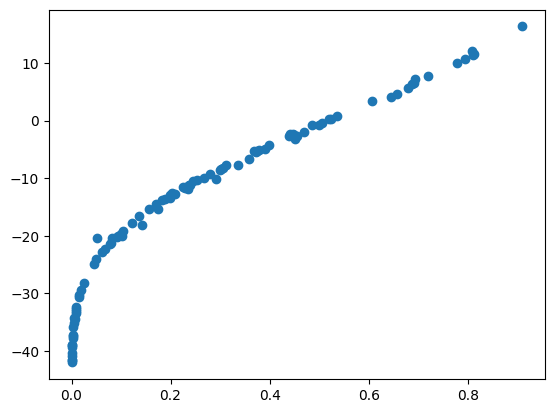

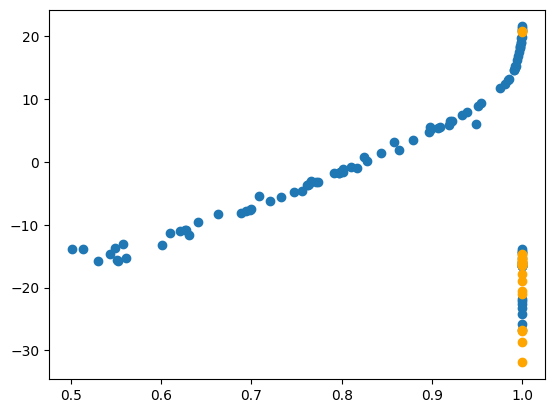

In [11]:
X_test, y_test = clf.generate_data(100)
y_test = y_test.detach().numpy()
skills_lac = np.take_along_axis(model_lac.predict_class_skills(X_test), y_test[:,np.newaxis], axis=1)
skills_aps = np.take_along_axis(model_aps.predict_class_skills(X_test), y_test[:,np.newaxis], axis=1)
conformity_scores_lac = oracle_annotator_lac.get_conformity(torch.tensor(X_test), torch.tensor(y_test))
conformity_scores_aps = oracle_annotator_aps.get_conformity(torch.tensor(X_test), torch.tensor(y_test))
print("tau lac", kendalltau(conformity_scores_lac, skills_lac))
print("tau aps",kendalltau(conformity_scores_aps, skills_aps))
print("gamma lac", goodman_kruskal_gamma(conformity_scores_lac, skills_lac))
print("gamma aps", goodman_kruskal_gamma(conformity_scores_aps, skills_aps))
plt.scatter(conformity_scores_lac, skills_lac)
plt.show()
plt.scatter(conformity_scores_aps, skills_aps)
plt.scatter(tied_nc, tied_sk, color="orange", label="tie")
plt.show()

In [13]:
# X_train, y_train = make_classification(
#     n_samples=100, n_features=3, n_classes=3, n_informative=3, n_redundant=0, n_repeated=0, n_clusters_per_class=1, random_state=42
# )

clf = clf_2d_2c

clf.fit(None, None)
num_instances_to_check = np.linspace(10,150,5).astype(int)

tau_corrs_LAC, gamma_corrs_LAC, skills_LAC, conformities_LAC, models_LAC, X_train_lac, y_train_lac = conduct_oracle_experiment(lac, num_instances_to_check, clf, num_epochs=250)
tau_corrs_APS, gamma_corrs_APS, skills_APS, conformities_APS, models_APS, X_train_aps, y_train_aps = conduct_oracle_experiment(aps, num_instances_to_check, clf, num_epochs=250)
# tau_corrs_SAPS, gamma_corrs_SAPS, skills_SAPS, conformities_SAPS, models_SAPS, X_train_saps, y_train_saps = conduct_oracle_experiment(saps, num_instances_to_check, clf, num_epochs=150)


/tmp/ipykernel_8993/749784010.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  conformities = oracle_annotator.get_conformity(torch.tensor(X_train),torch.tensor(y_train)).detach().numpy()


Epoch 1/250
  Train Loss: 0.2333
Epoch 2/250
  Train Loss: 0.2295
Epoch 3/250
  Train Loss: 0.2278
Epoch 4/250
  Train Loss: 0.2264
Epoch 5/250
  Train Loss: 0.2247
Epoch 6/250
  Train Loss: 0.2228
Epoch 7/250
  Train Loss: 0.2207
Epoch 8/250
  Train Loss: 0.2183
Epoch 9/250
  Train Loss: 0.2154
Epoch 10/250
  Train Loss: 0.2120
Epoch 11/250
  Train Loss: 0.2081
Epoch 12/250
  Train Loss: 0.2035
Epoch 13/250
  Train Loss: 0.1982
Epoch 14/250
  Train Loss: 0.1921
Epoch 15/250
  Train Loss: 0.1852
Epoch 16/250
  Train Loss: 0.1775
Epoch 17/250
  Train Loss: 0.1692
Epoch 18/250
  Train Loss: 0.1603
Epoch 19/250
  Train Loss: 0.1511
Epoch 20/250
  Train Loss: 0.1417
Epoch 21/250
  Train Loss: 0.1324
Epoch 22/250
  Train Loss: 0.1234
Epoch 23/250
  Train Loss: 0.1149
Epoch 24/250
  Train Loss: 0.1069
Epoch 25/250
  Train Loss: 0.0996
Epoch 26/250
  Train Loss: 0.0930
Epoch 27/250
  Train Loss: 0.0870
Epoch 28/250
  Train Loss: 0.0817
Epoch 29/250
  Train Loss: 0.0770
Epoch 30/250
  Train Lo

/tmp/ipykernel_8993/749784010.py:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  conformity_scores = oracle_annotator.get_conformity(torch.tensor(X_test), torch.tensor(y_test))


Epoch 1/250
  Train Loss: 0.0122
Epoch 2/250
  Train Loss: 0.0101
Epoch 3/250
  Train Loss: 0.0059
Epoch 4/250
  Train Loss: 0.0032
Epoch 5/250
  Train Loss: 0.0025
Epoch 6/250
  Train Loss: 0.0022
Epoch 7/250
  Train Loss: 0.0020
Epoch 8/250
  Train Loss: 0.0019
Epoch 9/250
  Train Loss: 0.0017
Epoch 10/250
  Train Loss: 0.0016
Epoch 11/250
  Train Loss: 0.0015
Epoch 12/250
  Train Loss: 0.0015
Epoch 13/250
  Train Loss: 0.0014
Epoch 14/250
  Train Loss: 0.0013
Epoch 15/250
  Train Loss: 0.0013
Epoch 16/250
  Train Loss: 0.0012
Epoch 17/250
  Train Loss: 0.0012
Epoch 18/250
  Train Loss: 0.0012
Epoch 19/250
  Train Loss: 0.0011
Epoch 20/250
  Train Loss: 0.0011
Epoch 21/250
  Train Loss: 0.0011
Epoch 22/250
  Train Loss: 0.0011
Epoch 23/250
  Train Loss: 0.0010
Epoch 24/250
  Train Loss: 0.0010
Epoch 25/250
  Train Loss: 0.0010
Epoch 26/250
  Train Loss: 0.0010
Epoch 27/250
  Train Loss: 0.0010
Epoch 28/250
  Train Loss: 0.0009
Epoch 29/250
  Train Loss: 0.0009
Epoch 30/250
  Train Lo

In [41]:
tau_corrs_own_aps = []
gamma_corrs_own_aps = []
oracle_annotator = OracleAnnotator(generator=clf, score=aps)

for model in models_LAC:
    model.eval()
    # generate data from data generating process and check whether the learned non-conformity relation sorts them correctly
    X_test, y_test = clf.generate_data(n_samples=100)
    # X_test = X_gen.repeat_interleave(3, dim=0)
    # y_test = np.tile(generator.classes_, 100)
    skills_from_model = model.predict_class_skills(X_test)
    own_aps = aps._calculate_single_label(-torch.tensor(skills_from_model), y_test).detach().numpy()
    # own_aps = np.take_along_axis(own_aps, y_test.detach().numpy()[:,np.newaxis], axis=1)
    aps_scores = oracle_annotator.get_conformity(X_test, y_test)
    tau_corr, p_value = kendalltau(own_aps, aps_scores)
    tau_corrs_own_aps.append(tau_corr)
    gamma_corr_own_aps = goodman_kruskal_gamma(own_aps,aps_scores)
    print(gamma_corr_own_aps)
    gamma_corrs_own_aps.append(gamma_corr_own_aps)


0.11106373907482413
0.38512671375155794
0.28065054211843204
0.2377548875341602
0.12211640211640212


In [54]:
tau_corrs_own_aps = []
gamma_corrs_own_aps = []
oracle_annotator = OracleAnnotator(generator=clf, score=lac)

for model in models_LAC:
    model.eval()
    # generate data from data generating process and check whether the learned non-conformity relation sorts them correctly
    X_test, y_test = clf.generate_data(n_samples=100)
    # X_test = X_gen.repeat_interleave(3, dim=0)
    # y_test = np.tile(generator.classes_, 100)
    skills_from_model = model(X_test)
    own_aps = aps._calculate_single_label(-torch.tensor(skills_from_model), y_test).detach().numpy()
    # own_aps = np.take_along_axis(own_aps, y_test.detach().numpy()[:,np.newaxis], axis=1)
    aps_scores = oracle_annotator.get_conformity(X_test, y_test)
    print(own_aps)
    print(aps_scores)
    tau_corr, p_value = kendalltau(own_aps, aps_scores)
    tau_corrs_own_aps.append(tau_corr)
    gamma_corr_own_aps = goodman_kruskal_gamma(own_aps,aps_scores)
    print(tau_corr)
    gamma_corrs_own_aps.append(gamma_corr_own_aps)

/tmp/ipykernel_8993/1712787509.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  own_aps = aps._calculate_single_label(-torch.tensor(skills_from_model), y_test).detach().numpy()


[10.755494   -0.12981701 -0.19825125 13.142162   -0.17961407  2.5288346
 13.194828   13.292824    8.648764   11.37862     4.7950854   9.370028
 12.418729    3.1728778  13.309031   10.790945   -0.15436268 13.0312605
 11.29977     8.398763    9.260271   -0.12853813  8.156244   13.261581
 12.193943   13.30792    13.073485    9.617339    6.17453     2.9931087
 -0.18742275  1.403715    6.3208504  11.505595    7.9061465   0.16031915
 -0.1972453   4.6992307  11.294329   12.033396    3.9509304   7.0152736
 11.531864   12.736454   12.44471     8.935745   13.220966    8.698498
 13.182817   10.498943    5.145232   13.260719   10.473669   -0.19854921
  3.9899962  13.300224    4.8446684  10.626253    4.2683287  11.025579
  6.89991     8.450895   -0.19271183 13.258425   10.834292   13.257304
  8.354896   13.002143   11.781426   10.898472   -0.1541462   5.6961355
  4.583225    8.340979   -0.15131569 -0.08690739 11.274041   11.639334
 13.286964   -0.1547308  11.255199   13.305541   11.550375    9.6086

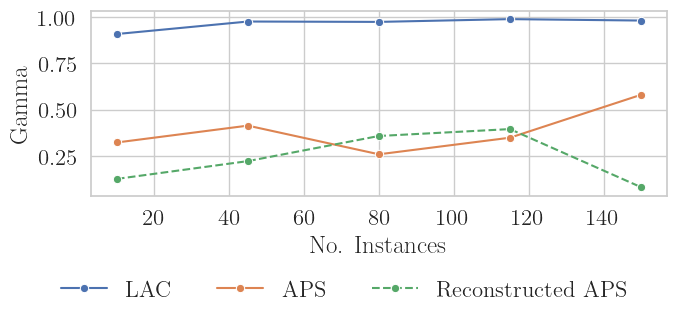

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5,rc={'text.usetex' : True})
sns.set_style("whitegrid")
plt.rc('font', **{'family': 'serif'})
plt.rcParams["figure.figsize"] = (7, 3)



fig, ax = plt.subplots()

ax.set_title("")
ax.set_ylabel(r"Gamma")
ax.set_xlabel(r"No. Instances")
# ax.set_ylim([0.0,1])
sns.lineplot(x=num_instances_to_check, y=gamma_corrs_LAC, ax = ax, marker="o",label="LAC", legend=False)
sns.lineplot(x=num_instances_to_check, y=gamma_corrs_APS, ax = ax, marker="o",label="APS", legend=False)
sns.lineplot(x=num_instances_to_check, y=gamma_corrs_own_aps, ax = ax, marker="o",label="Reconstructed APS", linestyle="--", legend=False)
# sns.lineplot(x=num_instances_to_check, y=gamma_corrs_SAPS, ax = ax, marker="o", label="SAPS", legend=False)
lgd = fig.legend(loc='upper center', ncol=3, bbox_to_anchor=(0.5, 0.08), frameon=False)

fig.tight_layout() 
plt.savefig("replicating.pdf",bbox_extra_artists=(lgd,), bbox_inches='tight')
# axes[1].set_title("APS")
# axes[1].set_ylabel(r"Kendalls $\tau$")
# axes[1].set_xlabel(r"No. Pairs")
# sns.lineplot(x=num_pairs_to_check, y=tau_corrs_APS, ax = axes[1])

In [40]:
print(tau_corrs_own_aps)

[0.09999375930051912, 0.2173710816406304, 0.34297302848060407, nan, nan]


SignificanceResult(statistic=nan, pvalue=nan)


/home/jonas/Documents/Research/torch_plnet/models/ranking_models.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  skills = self.forward(torch.tensor(X, dtype=torch.float32))


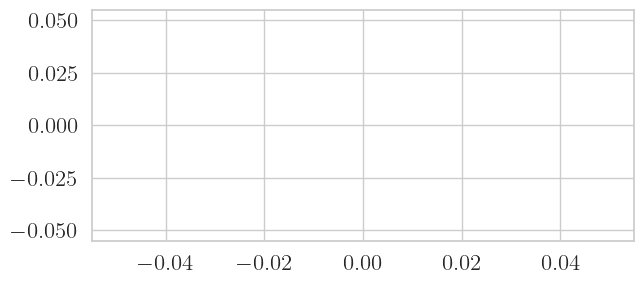

In [41]:
oa = OracleAnnotator(lac, clf)

cs = oa.get_conformity(X_train_lac, y_train_lac)
sk = models_LAC[-1].predict_class_skills(X_train_lac)
cs_model = np.take_along_axis(sk,y_train_lac[:,np.newaxis], axis=1)
print(kendalltau(cs, cs_model))

plt.scatter(cs.ravel(), cs_model.ravel())

SignificanceResult(statistic=nan, pvalue=nan)


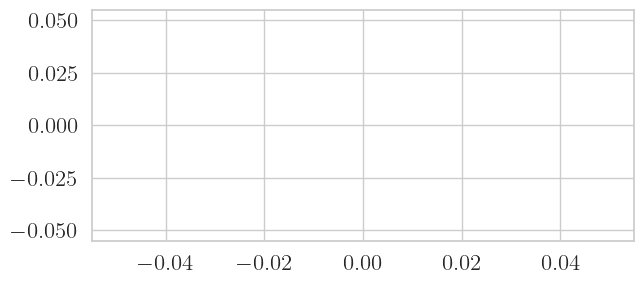

In [42]:
oa = OracleAnnotator(aps, clf)

cs = oa.get_conformity(X_train_lac, torch.tensor(y_train_lac))
sk = models_LAC[-1](X_train_lac)
aps_rec = aps(sk)
cs_aps_rec = np.take_along_axis(aps_rec,y_train_lac[:,np.newaxis], axis=1)

print(kendalltau(cs, cs_aps_rec.detach().numpy()))
plt.scatter(cs.ravel(), cs_aps_rec.detach().numpy().ravel())

/home/jonas/Documents/Research/torch_plnet/models/ranking_models.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  skills = self.forward(torch.tensor(X, dtype=torch.float32))


0.5048336391240438


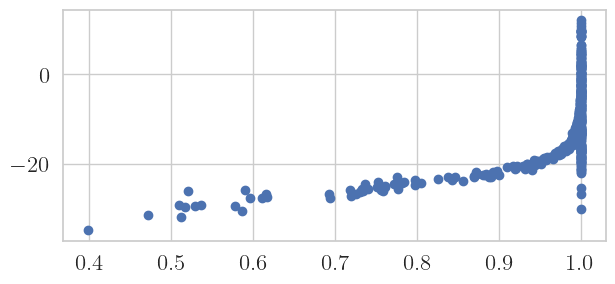

In [47]:
aps = APS(score_type="identity", randomized=False)
oa = OracleAnnotator(aps, clf)

cs = oa.get_conformity(X_train_aps, torch.tensor(y_train_aps))
sk = models_APS[-1].predict_class_skills(X_train_aps)
cs_model = np.take_along_axis(sk,y_train_aps[:,np.newaxis], axis=1)
print(goodman_kruskal_gamma(cs, cs_model))
plt.scatter(cs.ravel(), cs_model.ravel())


In [ ]:
from scipy.stats import entropy
probas = clf.predict_proba(X_train_lac).detach().numpy()
entropies = entropy(probas, base=3, axis=1)

(array([153.,  69.,  57.,  27.,  15.,  30.,  30.,  36.,  24.,   9.]),
 array([4.86309295e-05, 8.18236198e-02, 1.63598609e-01, 2.45373597e-01,
        3.27148586e-01, 4.08923575e-01, 4.90698564e-01, 5.72473553e-01,
        6.54248542e-01, 7.36023530e-01, 8.17798519e-01]),
 <BarContainer object of 10 artists>)

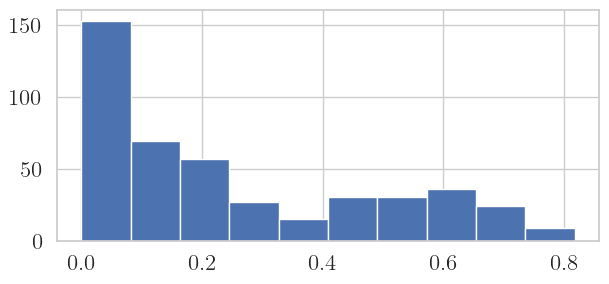

In [29]:
plt.hist(entropies)